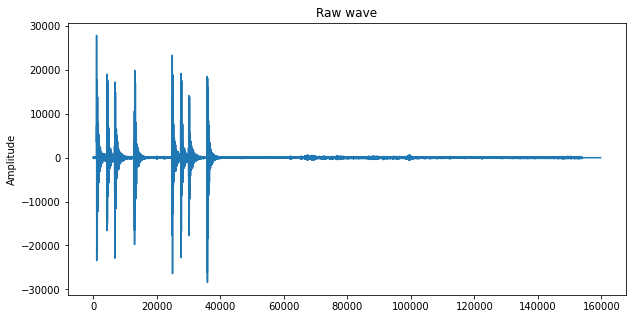

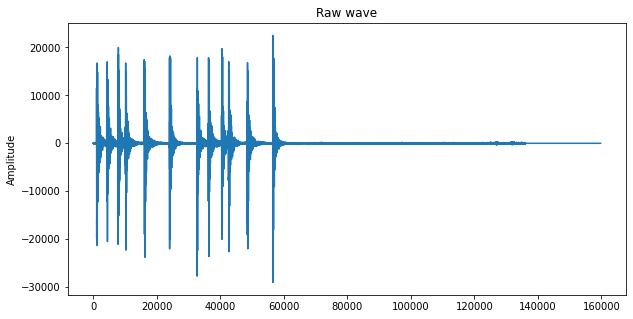

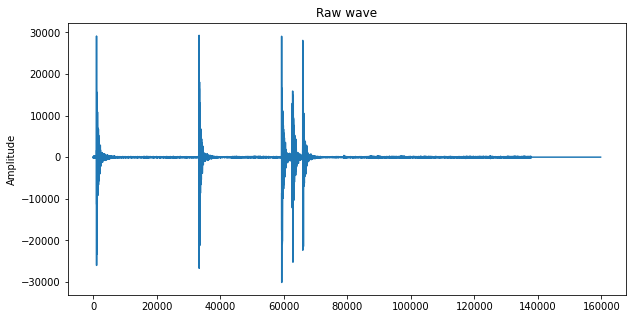

In [1]:
# Open wav file and load into numpy array
import numpy as np
import wave
import matplotlib.pyplot as plt
import os

dataFolder = "data/adjustedAudio/"

def load_wav_file(filename):
    wav = wave.open(filename, "r")
    frames = wav.readframes(-1)
    sound_info = np.frombuffer(frames, "int16")
    frame_rate = wav.getframerate()
    wav.close()
    return sound_info, frame_rate

def plot_wav_file(sound_info):
    plt.figure(num=None, figsize=(10, 5))
    plt.title('Raw wave')
    plt.ylabel('Amplitude')
    plt.plot(sound_info)
    plt.show()


signals = []
fileNames = []
for filename in os.listdir(dataFolder):
    if filename.endswith(".wav"):
        signals.append(load_wav_file(dataFolder + filename)[0])
        fileNames.append(filename)

# Plot the first, second, and 10th audio file
plot_wav_file(signals[0])
plot_wav_file(signals[1])
plot_wav_file(signals[9])
    




In [2]:
# Normalize the audio files so that 30000 is now 1
# This is so that we can compare the audio files
# to each other
def normalize_audio(signal):
    return signal / 30000

normalized_signals = []

for signal in signals:
    normalized_signals.append(normalize_audio(signal))


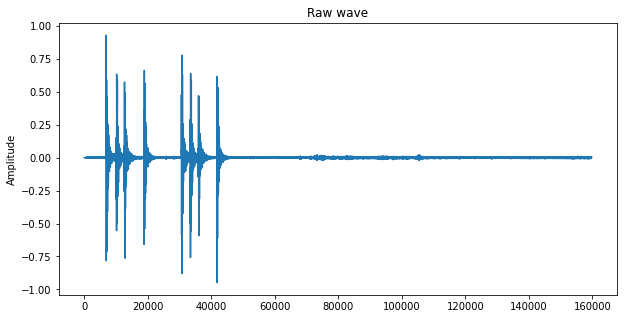

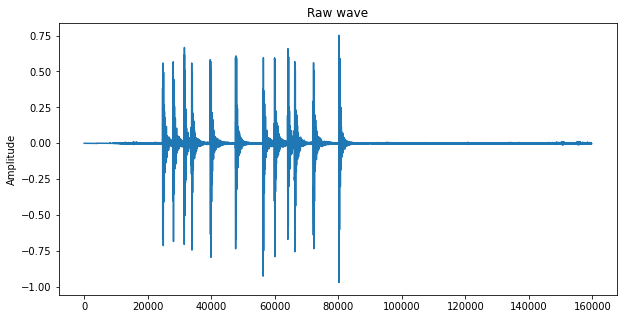

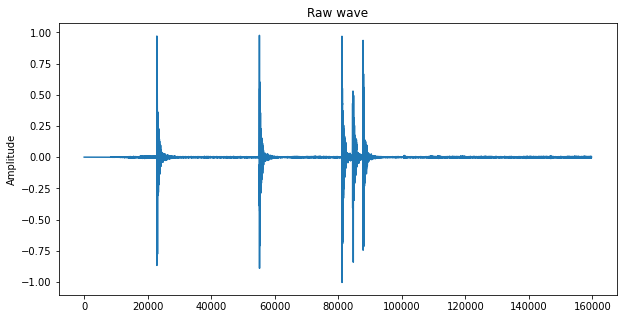

In [18]:
# Plot the first, second, and 10th audio file
plot_wav_file(normalized_signals[0])
plot_wav_file(normalized_signals[1])
plot_wav_file(normalized_signals[9])

1/1 [==============================] - 0s 87ms/step


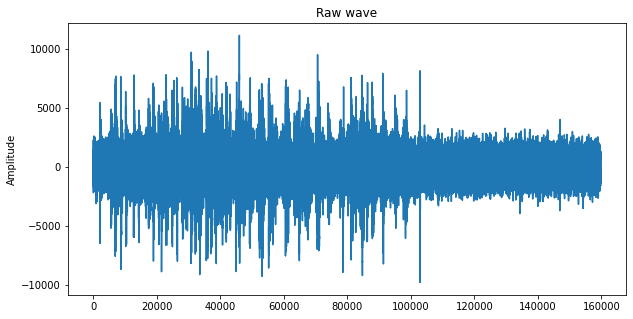

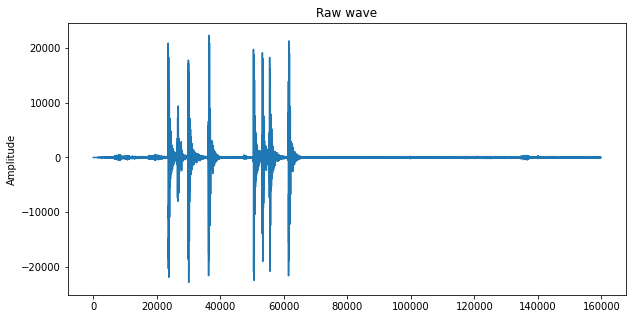

In [ ]:
nthPred = 21

# Predict the compressed signal from the first audio file
compressed_signal = autoencoder.predict(np.array([normalized_signals[nthPred]]))

# Save the compressed signal
compressed_signal = compressed_signal[0] * 30000
compressed_signal = np.array(compressed_signal, dtype=np.int16)
wavefile = wave.open("compressed_signal.wav", "w")
wavefile.setnchannels(1)
wavefile.setsampwidth(2)
wavefile.setframerate(20000)
wavefile.writeframes(compressed_signal)
wavefile.close()


# Plot the compressed signal
plot_wav_file(compressed_signal)

# plot the original signal
plot_wav_file(normalized_signals[nthPred] * 30000)

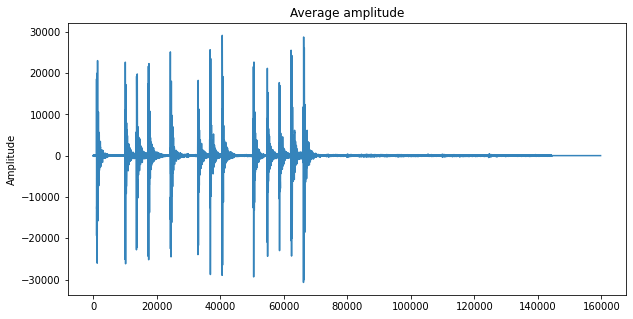

In [3]:
# Plot the average amplitude of the audio file
def plot_average_amplitude(signal, title="Average amplitude"):
    plt.figure(num=None, figsize=(10, 5))
    plt.title(title)
    plt.ylabel('Amplitude')
    # plt.axhline(np.average(np.abs(signal)) * 5, color='r')
    plt.plot(signal, alpha=0.9)
    plt.show()

plot_average_amplitude(normalized_signals[10] * 30000)

In [20]:

# This function split the audio into exiciting short segments of claps
def split_signal(signal, nums, size, duration = 1000):
    excitingIndexes = []
    aboveAverage = np.average(np.abs(signal)) * 5
    for i in range(len(signal)):
        if signal[i] > aboveAverage:
            excitingIndexes.append(i)

    # vary excitingIndexes by +- 1000
    for i in range(len(excitingIndexes)):
        excitingIndexes[i] = excitingIndexes[i] + np.random.randint(-2000, 2000)
    
    # remove indexes that are out of bounds
    for i in range(len(excitingIndexes)):
        if excitingIndexes[i] < 0 or excitingIndexes[i] > len(signal):
            excitingIndexes.pop(i)
    
    # Sample with replacement nums times
    excitingIndexes = np.random.choice(excitingIndexes, nums, replace=True)

    signals = []

    for i in range(len(excitingIndexes)):
        if(excitingIndexes[i] + size < len(signal)):
            signals.append(signal[excitingIndexes[i]:excitingIndexes[i] + size])
        else:
            signals.append(signal[excitingIndexes[i] - size: excitingIndexes[i]])
    
    return signals

signals = []

for normalAudio in normalized_signals:
    split_sigs = split_signal(normalAudio, 200, 1000)
    signals += split_sigs


In [21]:
len(signals)

5400

In [22]:
# Make a smaller autoencoder model to compress the audio signal
# Make a autoencoder model to compress the audio signal
from tensorflow.keras.layers import Input, Dense

train = False
if(train):
    # Input layer
    input_layer = Input(shape=(len(signals[0]),))
    # Encoder layers
    encoded = Dense(256, activation="tanh")(input_layer)
    encoded = Dense(128, activation="tanh")(encoded)
    encoded = Dense(64, activation="tanh")(encoded)
    # Latent view
    latent_view = Dense(32, activation="tanh")(encoded)
    # Decoder layers
    decoded = Dense(64, activation="tanh")(latent_view)
    decoded = Dense(128, activation="tanh")(decoded)
    decoded = Dense(256, activation="tanh")(decoded)
    # Output layer set range to 0 to 30000
    output_layer = Dense(len(signals[0]), activation="tanh")(decoded)

    # Compile the model
    from tensorflow.keras.models import Model

    autoencoder = Model(input_layer, output_layer)
    autoencoder.compile(optimizer="adam", loss="mse")
    autoencoder.summary()

    # Save model every 100 epochs
    from tensorflow.keras.callbacks import ModelCheckpoint

    checkpoint_name = "modelCheckpoints/Weights-smallmodel3-{epoch:03d}--{val_loss:.5f}.hdf5"
    checkpoint = ModelCheckpoint(checkpoint_name, monitor="val_loss", verbose=1, save_best_only=True, mode="auto")
    callbacks_list = [checkpoint]

    # Train the model
    autoencoder.fit(np.array(signals), np.array(signals), epochs=500, batch_size=32, shuffle=True, validation_split=0.2, callbacks=callbacks_list)

    # Plot the loss
    plt.plot(autoencoder.history.history["loss"], label="Training loss")



5/5 [==============================] - 0s 2ms/step


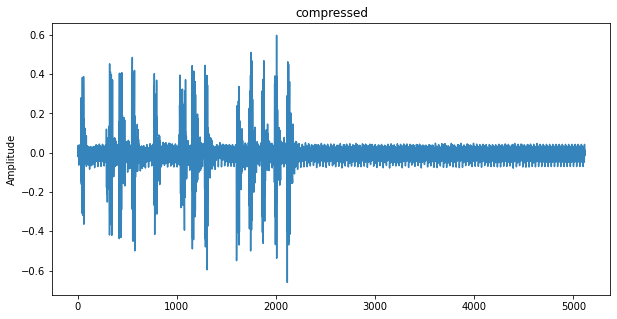

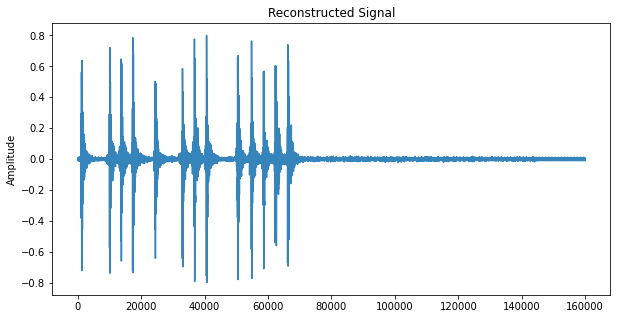

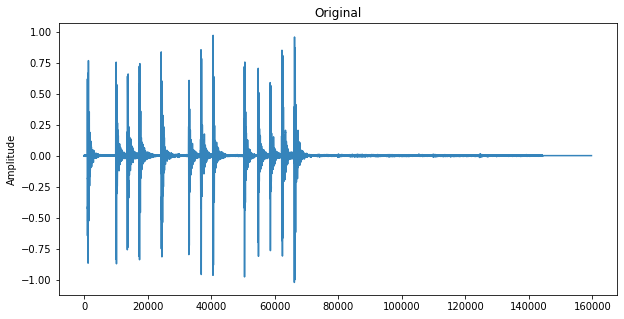

In [5]:
# Load checkpoint
from tensorflow.keras.models import load_model
#Import the Model from keras
from tensorflow.keras.models import Model

autoencoder = load_model("modelCheckpoints/Weights-smallmodel2-315--0.00202.hdf5")
encoder = Model(inputs=autoencoder.input, outputs=autoencoder.get_layer('dense_3').output)
decoder = Model(inputs=autoencoder.get_layer('dense_4').input, outputs=autoencoder.output)


def split_into_peices(signal, size):
    pieces = []

    i = 0
    while i < len(signal):
        if i + size < len(signal):
            pieces.append(np.array(signal[i:i+size]))
        else:
            t = np.array(signal[i:])
            t = np.pad(t, (0, size - len(t)), 'constant')
            pieces.append(t)

        i += size

    return pieces

def compress_signal(signal):
    # split normalised signals into 1000 long segments for prediction
    pieces = split_into_peices(signal, 1000)

    encoded = encoder.predict(np.array(pieces))
    
    return np.concatenate(encoded, axis=0)

def decompress_signal(compressed_signal):
    # split normalised signals into 32 long segments for prediction
    pieces = split_into_peices(compressed_signal, 32)

    decoded = decoder.predict(np.array(pieces))
    
    return np.concatenate(decoded, axis=0)

def save_audio(signal, filename, denormalize=True):
    if denormalize:
        signal = signal * 30000
    
    signal = np.array(signal, dtype=np.int16)
    wavefile = wave.open(filename, "w")
    wavefile.setnchannels(1)
    wavefile.setsampwidth(2)
    wavefile.setframerate(20000)
    wavefile.writeframes(signal)
    wavefile.close()



compressed_signal = compress_signal(normalized_signals[10])
decompressed_signal = decompress_signal(compressed_signal)

save_audio(decompressed_signal, "compressed_10.wav")

plot_average_amplitude(compressed_signal, title = "compressed")
plot_average_amplitude(decompressed_signal, title = "Reconstructed Signal")
plot_average_amplitude(normalized_signals[10], title="Original")


In [36]:
# Use all normalised signals to compress
compressed_signals = []

for normalAudio in normalized_signals:
    compressed_signals.append(compress_signal(normalAudio))

folderToSave = "data/compressedSignalsAdjusted/"

print("filenames")
print(fileNames)
# Save compressed signals with filename + compressed
for i in range(len(compressed_signals)):
    f = open(folderToSave + fileNames[i][:-4] + ".npy", "wb+")
    np.save(f, compressed_signals[i])

5/5 [==============================] - 0s 2ms/step
filenames
['aejvqoknnp.wav', 'afceoescqs.wav', 'cgxwaehnir.wav', 'dumxartuej.wav', 'fseivkaego.wav', 'heddrodrmd.wav', 'ieaxshpxwj.wav', 'iiuanaofgh.wav', 'jpjcecupwp.wav', 'kttcqvdgul.wav', 'mokhicvkqf.wav', 'mxhplmsaoy.wav', 'nekumenpgv.wav', 'nvdmllxvqy.wav', 'oagvqxyqxz.wav', 'ooyevtcxvf.wav', 'pxtgqsabnh.wav', 'rjrqbatlca.wav', 'rupzhrxnvo.wav', 'tkaorzfyzc.wav', 'tsoxcpgasb.wav', 'ugsvpqnwjq.wav', 'uqvsgllfeq.wav', 'xmclwscjcz.wav', 'xwrxxvztrb.wav', 'ztvloagxul.wav', 'zviuujuuou.wav']
